<a href="https://colab.research.google.com/github/bbutka/CEC220/blob/main/Karnaugh_Full2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If entering a logic expression use + for OR and use & for AND   
Use ! to invert variables A' is !A
example (A+B)&(!A+C)

RadioButtons(description='Variables:', options=(3, 4), value=None)

(A | B) & (C | ~A)
A | B | C | f
-------------
0 | 0 | 0 | 0
0 | 0 | 1 | 0
0 | 1 | 0 | 1
0 | 1 | 1 | 1
1 | 0 | 0 | 0
1 | 0 | 1 | 1
1 | 1 | 0 | 0
1 | 1 | 1 | 1

Simplified expression for f: (A & C) + (B & !A)


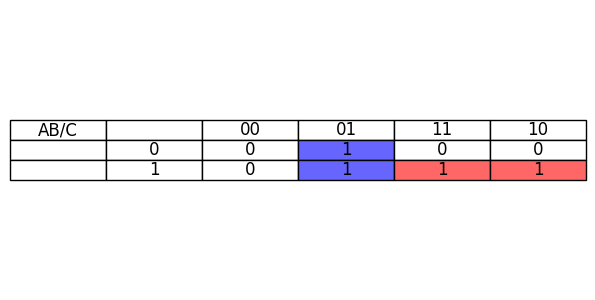

In [ ]:
# @title
import sympy as sp
import re
import itertools
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, to_hex
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import Layout, HBox, VBox, HTML, RadioButtons

# Original strong colors
colors = ['#FF0000', '#0000FF', '#FFFF00', '#00FF00', '#FFA500', '#800080', '#FFFFFF']

def lighten_color(color, amount=0.5):
    """Lightens the given color by mixing it with white."""
    white = np.array([1, 1, 1])
    color = np.array(to_rgb(color))
    return to_hex((1 - amount) * color + amount * white)

# Lightened colors
lightened_colors = [lighten_color(color, 0.4) for color in colors]

def blend_colors(color1, color2):
    """Blends two colors together by averaging their RGB values."""
    rgb1 = to_rgb(color1)
    rgb2 = to_rgb(color2)
    blended_rgb = [(c1 + c2) / 2 for c1, c2 in zip(rgb1, rgb2)]
    return to_hex(blended_rgb)

def generate_truth_table_input(num_vars):
    """Generate input widgets for the truth table."""
    rows = 2**num_vars
    cols = num_vars + 1  # Variables and F
    table_input = []
    headers = [chr(65 + i) for i in range(num_vars)] + ["F"]
    style = HTML(
        "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box"
        " label{margin:5px !important;width: 50px !important;}</style>",
        layout=Layout(display="none"),
    )

    for i in range(rows):
        row_widgets = []
        for j in range(cols - 1):  # Inputs (A, B, C, ...)
            row_widgets.append(widgets.Label(value=str((i >> (num_vars - 1 - j)) & 1), layout=Layout(width='30px')))
        # Output (F)
        radio_buttons = RadioButtons(options=['1', '0', 'X'], value='0', layout=Layout(width='200px', display='flex', flex_direction='row'))
        row_widgets.append(HBox([radio_buttons, style]))
        table_input.append(row_widgets)
    return table_input, headers

def display_truth_table(table_input, headers):
    """Display the truth table input widgets."""
    header_widgets = [widgets.Label(value=header, layout=Layout(width='30px')) for header in headers]
    table_input_widgets = [HBox(row, layout=Layout(margin='0')) for row in table_input]
    return VBox([HBox(header_widgets)] + table_input_widgets)

def parse_truth_table_input(table_input):
    """Parse the user input from the truth table."""
    truth_table = []
    for row in table_input:
        truth_row = [int(row[i].value) for i in range(len(row) - 1)]
        output = row[-1].children[0].value.strip().upper()
        truth_row.append(output)
        truth_table.append(truth_row)
    return truth_table

def simplify_expression_from_truth_table(truth_table, num_vars):
    """Simplify the logic expression based on the truth table using Quine-McCluskey algorithm."""
    variables = sp.symbols(' '.join([chr(65 + i) for i in range(num_vars)]))
    minterms = []
    dont_cares = []
    for row in truth_table:
        if row[-1] == '1':
            minterms.append(row[:num_vars])
        elif row[-1] == 'X':
            dont_cares.append(row[:num_vars])

    # Convert minterms and don't-cares to integers
    minterms_int = [int(''.join(map(str, m)), 2) for m in minterms]
    dont_cares_int = [int(''.join(map(str, dc)), 2) for dc in dont_cares]

    # Use SymPy's SOPform with minterms and don't-cares
    simplified_expr = sp.SOPform(variables, minterms=minterms_int, dontcares=dont_cares_int)
    return simplified_expr

def convert_to_original_format(expr):
    expr_str = str(expr)
    expr_str = expr_str.replace('~', '!')
    expr_str = expr_str.replace('|', '+')
    return expr_str

def draw_karnaugh_map(truth_table, simplified_expr, variables):
    num_vars = len(variables)
    if num_vars == 3:
        draw_karnaugh_map_3var(truth_table, simplified_expr, variables)
    elif num_vars == 4:
        draw_karnaugh_map_4var(truth_table, simplified_expr, variables)

def draw_karnaugh_map_3var(truth_table, simplified_expr, variables):
    kmap = {}
    for row in truth_table:
        A, B, C, result = row
        kmap[(A, B, C)] = result

    # Define the Karnaugh map structure with A and B on columns and C on rows
    columns = [(0, 0), (0, 1), (1, 1), (1, 0)]
    rows = [0, 1]

    # Initialize the Karnaugh map
    kmap_layout = np.full((2, 4), '', dtype=object)

    # Fill the Karnaugh map with values from the truth table
    for (A, B, C), result in kmap.items():
        col_index = columns.index((A, B))
        row_index = rows.index(C)
        kmap_layout[row_index, col_index] = str(result)

    # Highlight the minterms in the Karnaugh map
    color_map = np.full((2, 4), 'white', dtype=object)

    terms = simplified_expr.args if simplified_expr.func == sp.Or else [simplified_expr]
    color_index = 0
    for term in terms:
        color = lightened_colors[color_index % len(lightened_colors)]
        minterms = []
        if term.func == sp.And:
            minterms = [term]
        else:
            minterms = term.args if term.func == sp.Or else [term]

        for minterm in minterms:
            vars_values = {v: -1 for v in variables}
            for arg in minterm.args if minterm.func == sp.And else [minterm]:
                if arg.func == sp.Not:
                    vars_values[arg.args[0]] = 0
                else:
                    vars_values[arg] = 1

            for row in truth_table:
                A, B, C, result = row
                match = all((vars_values[variables[i]] == val or vars_values[variables[i]] == -1) for i, val in enumerate([A, B, C]))
                if match:
                    col_index = columns.index((A, B))
                    row_index = rows.index(C)
                    current_color = color_map[row_index, col_index]
                    if current_color == 'white':
                        color_map[row_index, col_index] = color
                    else:
                        color_map[row_index, col_index] = blend_colors(current_color, color)

        color_index += 1

    # Create the Karnaugh map plot
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figure size to reduce white space
    plt.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.9, hspace=0, wspace=0)  # Adjust layout parameters

    # Create an empty layout for the table with 3 rows and 6 columns
    table_data = np.full((3, 6), '', dtype=object)
    cell_colors = np.full((3, 6), 'white', dtype=object)

    # Place the variable names and labels
    table_data[0, 0] = 'AB/C'
    table_data[0, 1] = ''
    table_data[0, 2] = '00'
    table_data[0, 3] = '01'
    table_data[0, 4] = '11'
    table_data[0, 5] = '10'
    table_data[1, 0] = ''
    table_data[1, 1] = '0'
    table_data[2, 1] = '1'

    # Fill the Karnaugh map values in the table
    for i in range(2):
        for j in range(4):
            table_data[i + 1, j + 2] = kmap_layout[i, j]
            cell_colors[i + 1, j + 2] = color_map[i, j]

    # Draw the table
    table = ax.table(cellText=table_data, cellColours=cell_colors, cellLoc='center', loc='center', edges='closed')

    # Format the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    # Center the variable names in their respective cells
    for key, cell in table.get_celld().items():
        if key == (0, 0):
            cell.set_text_props(ha='center', va='center')
        elif key ==(1, 0):
            cell.set_text_props(ha='center', va='center', rotation=0)
        elif key == (2, 0):
            cell.set_text_props(ha='center', va='center', rotation=0)

    # Remove the axis
    ax.axis('off')

    plt.show()

def parse_logic_expression(expression, num_vars):
    # Ignore leading 'f=' if present
    if expression.startswith('f='):
        expression = expression[2:]

    # Replace logical NOT '!' with SymPy '~'
    expression = expression.replace('!', '~')
    # Replace logical OR '+' with SymPy '|'
    expression = expression.replace('+', '|')

    # Insert explicit AND '&' where it is implied by juxtaposition
    expression = re.sub(r'([A-Z])(?=[A-Z~])', r'\1 & ', expression)
    expression = re.sub(r'~\s*&', '~', expression)  # Fix for NOT operator

    # Parse the expression using SymPy
    variables = sp.symbols(' '.join(['A', 'B', 'C', 'D'][:num_vars]))
    parsed_expression = sp.sympify(expression, locals={v.name: v for v in variables})
    return parsed_expression, variables

def simplify_expression(expr):
    simplified_expr = sp.simplify_logic(expr, form='dnf')
    return simplified_expr

def convert_to_original_format(expr):
    expr_str = str(expr)
    expr_str = expr_str.replace('~', '!')
    expr_str = expr_str.replace('|', '+')
    return expr_str

def draw_karnaugh_map_4var(truth_table, simplified_expr, variables):
    kmap = {}
    for row in truth_table:
        A, B, C, D, result = row
        kmap[(A, B, C, D)] = result

    # Define the Karnaugh map structure with A and B on columns and C, D on rows
    columns = [(0, 0), (0, 1), (1, 1), (1, 0)]
    rows = [(0, 0), (0, 1), (1, 1), (1, 0)]

    # Rearrange rows to match the specified minterms order
    row_order = [0, 1, 2, 3]

    # Initialize the Karnaugh map
    kmap_layout = np.full((4, 4), '', dtype=object)

    # Fill the Karnaugh map with values from the truth table
    for (A, B, C, D), result in kmap.items():
        col_index = columns.index((A, B))
        row_index = row_order[rows.index((C, D))]
        kmap_layout[row_index, col_index] = str(result)

    # Highlight the minterms in the Karnaugh map
    color_map = np.full((4, 4), 'white', dtype=object)

    terms = simplified_expr.args if simplified_expr.func == sp.Or else [simplified_expr]
    color_index = 0
    for term in terms:
        color = lightened_colors[color_index % len(lightened_colors)]
        minterms = []
        if term.func == sp.And:
            minterms = [term]
        else:
            minterms = term.args if term.func == sp.Or else [term]

        for minterm in minterms:
            vars_values = {v: -1 for v in variables}
            for arg in minterm.args if minterm.func == sp.And else [minterm]:
                if arg.func == sp.Not:
                    vars_values[arg.args[0]] = 0
                else:
                    vars_values[arg] = 1

            for row in truth_table:
                A, B, C, D, result = row
                match = all((vars_values[variables[i]] == val or vars_values[variables[i]] == -1) for i, val in enumerate([A, B, C, D]))
                if match:
                    col_index = columns.index((A, B))
                    row_index = row_order[rows.index((C, D))]
                    current_color = color_map[row_index, col_index]
                    if current_color == 'white':
                        color_map[row_index, col_index] = color
                    else:
                        color_map[row_index, col_index] = blend_colors(current_color, color)

        color_index += 1

    # Create the Karnaugh map plot
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figure size to reduce white space
    plt.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.9, hspace=0, wspace=0)  # Adjust layout parameters

    # Create an empty layout for the table with 5 rows and 6 columns
    table_data = np.full((5, 6), '', dtype=object)
    cell_colors = np.full((5, 6), 'white', dtype=object)

    # Place the variable names and labels
    table_data[0, 0] = 'AB/CD'
    table_data[0, 1] = ''
    table_data[0, 2] = '00'
    table_data[0, 3] = '01'
    table_data[0, 4] = '11'
    table_data[0, 5] = '10'
    table_data[1, 0] = '00'
    table_data[2, 0] = '01'
    table_data[3, 0] = '11'
    table_data[4, 0] = '10'

    # Fill the Karnaugh map values in the table
    for i in range(4):
        for j in range(4):
            table_data[i + 1, j + 2] = kmap_layout[i, j]
            cell_colors[i + 1, j + 2] = color_map[i, j]

    # Draw the table
    table = ax.table(cellText=table_data, cellColours=cell_colors, cellLoc='center', loc='center', edges='closed')

    # Format the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    # Center the variable names in their respective cells
    for key, cell in table.get_celld().items():
        if key == (0, 0):
            cell.set_text_props(ha='center', va='center')
        elif key in [(1, 0), (2, 0), (3, 0), (4, 0)]:
            cell.set_text_props(ha='center', va='center', rotation=0)

    # Remove the axis
    ax.axis('off')

    plt.show()

def print_truth_table(expr, variables):
    # Generate all possible combinations of truth values for the variables
    num_vars = len(variables)
    combinations = list(product([0, 1], repeat=num_vars))

    # Print the table header
    header = " | ".join([str(var) for var in variables]) + " | f"
    print(header)
    print("-" * len(header))

    truth_table = []

    # Print each row of the truth table
    for combination in combinations:
        values = {var: val for var, val in zip(variables, combination)}
        result = expr.subs(values)
        row = list(combination) + [int(bool(result))]
        truth_table.append(row)
        print(" | ".join([str(val) for val in row]))

    return truth_table

def main():
    def reset_all():
        clear_output(wait=True)
        main()

    num_vars_selector = widgets.RadioButtons(
        options=[3, 4],
        value=None,  # Ensure the radio buttons start off unselected
        description='Variables:',
        disabled=False
    )
    display(num_vars_selector)

    method = widgets.RadioButtons(
        options=['Enter Logic Expression', 'Enter Truth Table'],
        value=None,  # Ensure the radio buttons start off unselected
        description='Method:',
        disabled=False
    )
    method_container = VBox([method])
    display(method_container)

    def on_method_change(change):
        if change['new'] == 'Enter Logic Expression':
            display(VBox([text_input, button_expr, button_restart]))
        elif change['new'] == 'Enter Truth Table':
            if num_vars_selector.value is not None:
                global table_input, headers
                table_input, headers = generate_truth_table_input(num_vars_selector.value)
                method_container.close()  # Hide the method selection widgets
                display(VBox([display_truth_table(table_input, headers), button_tt, button_restart]))
            else:
                print("Please select the number of variables first.")

    def on_num_vars_change(change):
        if method.value == 'Enter Truth Table' and change['new'] is not None:
            global table_input, headers
            table_input, headers = generate_truth_table_input(change['new'])
            method_container.close()  # Hide the method selection widgets
            display(VBox([display_truth_table(table_input, headers), button_tt, button_restart]))

    method.observe(on_method_change, names='value')
    num_vars_selector.observe(on_num_vars_change, names='value')

    text_input = widgets.Textarea(
        value='',
        placeholder='Type the boolean expression here...',
        description='Expression:',
        layout=widgets.Layout(width='50%', height='100px'),
        disabled=False
    )

    button_expr = widgets.Button(description="Generate Karnaugh Map")
    button_expr.on_click(lambda b: handle_expression(text_input.value, num_vars_selector.value))

    button_tt = widgets.Button(description="Generate Karnaugh Map")
    button_tt.on_click(lambda b: handle_truth_table(num_vars_selector.value))

    button_restart = widgets.Button(description="Restart")
    button_restart.on_click(lambda b: reset_all())

    def handle_expression(expression, num_vars):
        if num_vars is None:
            print("Please select the number of variables first.")
            return
        parsed_expression, variables = parse_logic_expression(expression, num_vars)
        print(parsed_expression)
        truth_table = print_truth_table(parsed_expression, variables)
        simplified_expr = simplify_expression(parsed_expression)
        original_format_expr = convert_to_original_format(simplified_expr)
        print(f"\nSimplified expression for f: {original_format_expr}")
        draw_karnaugh_map(truth_table, simplified_expr, variables)

    def handle_truth_table(num_vars):
        if num_vars is None:
            print("Please select the number of variables first.")
            return
        truth_table = parse_truth_table_input(table_input)
        simplified_expr = simplify_expression_from_truth_table(truth_table, num_vars)
        original_format_expr = convert_to_original_format(simplified_expr)
        print(f"\nSimplified expression for f: {original_format_expr}")
        draw_karnaugh_map(truth_table, simplified_expr, sp.symbols(' '.join([chr(65 + i) for i in range(num_vars)])))

main()
